In [1]:
from sympy import *
interactive.printing.init_printing(use_latex=True)
from sympy.physics.vector import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import axes3d
warnings.simplefilter('ignore')
import multiprocessing as mp

In [2]:
# r is the radius of the quartz fiber
# beta is the characteristic angle of the light rays
r , b = symbols('r beta')
# alpah is the angle of the cone
a = b/2 + pi/4
# l is the length of the cone
l = (0.15 + r - 0.075)*sin(b)/sin(a-b)
# hc is the height of the cone
hc = l*sin(a)
# d is the minimal distance between the edges of adjacent fibers
dy = 0.18
# R is the large radius of the cone
R = r + hc*cot(a)
a = float(a.subs([(b,pi/4),(r,0.09)]).evalf())
l = float(l.subs([(b,pi/4),(r,0.09)]).evalf())
# dy = float(dy.subs(b,pi/4).subs(r,0.09).evalf())
R = float(R.subs(b,pi/4).subs(r,0.09).evalf())
hc = float(hc.subs([(b,pi/4),(r,0.09)]).evalf())
print(f'hc= {hc}')
print(f'R= {R}')
print(f'l= {l}')
print(np.rad2deg(a))

# base limits are (-xb,xb)x(-yb,yb) [cm]  
xb = 4.89/2
yb = 4.64/2

# PMT limits are (-xp,xp)x(-yp,yp) [cm]
xp = 0.5
yp = 1.16/2

# the height is also a constant measured in [cm]
h = 7

# the number of quartz fibers, the distance between them, and location of first fiber are constant
nx = 5
dx = 0.7
x0 = 0.5*(nx-1)*dx
ny = int(2*yb/dy)
y0 = 0.5*(ny-1)*dy
# for vector operations
N = ReferenceFrame('N')

# for plotting
r_vec = np.linspace(0,2.69, 20)
theta_vec = np.linspace(-np.pi, np.pi, 40)
r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

x_vec = r_vec * np.sin(theta_vec)
y_vec = r_vec * np.cos(theta_vec)
# here we choose a paraboloid which is symmetric with respect to the z axis
# ergo, z = a(x**2+y**2) + c. Constraining the focus at (0,0,h), and also passing through (x2,0,h)- all is determined.
m = -1/(2*yp)
z2 = m*(N[0]**2 + N[1]**2) + h - 1/(4*m)
# display(z2)
# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(111, projection='3d')
# z_vec = lambdify((N[0],N[1]),z2,modules=['numpy'])
# ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))
# plt.show()

hc= 0.2816726188957803
R= 0.2066726188957803
l= 0.3048802457287246
67.5


In [22]:
def Ray_Generator_ZDC():
    # Chooses a fiber/rod in random, from a defined grid
    np.random.seed()
    xc = -x0 + np.random.randint(low=0,high=nx,size=None)*dx
    yint = np.random.randint(low=0,high=ny,size=None)
    yc = -y0 + yint*dy

    # The ray is generated from a random point on the circular base surface of the rod (radius r)
    rand_arg = np.random.uniform(-np.pi,np.pi)
    rand_rad = np.random.uniform(0,0.065)
    xs = xc + rand_rad * np.cos(rand_arg)
    ys = yc + rand_rad * np.sin(rand_arg)
    pc = xc * N.x + yc * N.y + 0 * N.z
    ps = xs * N.x + ys * N.y + 0 * N.z
    
    # Chooses random orientation for the ray, polar angle distributed normally around 45 degrees. Narrow width.
    theta = np.random.normal(np.pi/4,np.pi/12)
    phi = np.random.uniform(-np.pi,np.pi)
    es = np.cos(phi)*np.sin(theta) * N.x + np.sin(phi)*np.sin(theta) * N.y + np.cos(theta) * N.z 
    # Returns a point and a unit vector, which characterize a straight line (the light ray before reflection).
    return pc,ps,es,bool(yint%2)

def Ray_Generator_Parallel():
    np.random.seed()
    xs = np.random.uniform(-x0,x0)
    ys = np.random.uniform(-y0,y0)
    
    ps = xs*N.x + ys*N.y
    es = 1*N.z
    return ps,es

ray_x = lambda z,p,e: (p & N.x)+(e & N.x)/(e & N.z)*(z-(p & N.z))
ray_y = lambda z,p,e: (p & N.y)+(e & N.y)/(e & N.z)*(z-(p & N.z))

def Intersection(surface,p,e,bottom,top):
    # takes in the equation of the reflector surface
    # and also a point and a vector, describing a light ray traveling along a straight line
    if ((e & N.z) == 0):
        g = symbols('gamma',positive=True , real=True)
        xi = (p & N.x) + g * float(e & N.x)
        yi = (p & N.y) + g * float(e & N.y)
        zi = (p & N.z) + g * float(e & N.z)
        g_arr = np.array(solve(surface.subs([(N[0],xi),(N[1],yi)]),g,check=False)) # we will only get one solution
        xi = xi.subs(g,float(g_arr[0]))
        yi = yi.subs(g,float(g_arr[0]))
        return xi * N.x + yi * N.y
    else:
        x_z = (p & N.x) + (N[2] - (p & N.z))*(e & N.x)/(e & N.z)
        y_z = (p & N.y) + (N[2] - (p & N.z))*(e & N.y)/(e & N.z)
        surface = surface.subs([(N[0],x_z),(N[1],y_z)])
        sol = symbols('chi', positive=True, real=True) # this is needed because sympy doesn't handle radical equation very well
        surface = simplify(surface.subs(N[2],sol))
        sol_arr = np.array(solve(sol - surface,sol)) ## solve for intersection z
    for i in range(len(sol_arr)):
        if sol_arr[i].is_real:
            zi = float(sol_arr[i])
            if bottom <= zi <= top : ## if the ray intersects the boundary inside the light guide, we return the intersection
                return x_z.subs(N[2],zi) * N.x + y_z.subs(N[2],zi) * N.y + zi * N.z
    return 0 * N.x + 0* N.y ## otherwise, we return (0,0,0) and thus know it doesn't reflect off of the boundary

def Bisection(fc,p,e,height):
    # same purpose as 'Intersection'
    # uses a numerical method for solving, instead of analytical
    g = symbols('gamma',positive=True,real=True)
    xi = (p & N.x) + g * (e & N.x) # this is the parametric representation of the light ray straight line
    yi = (p & N.y) + g * (e & N.y)
    zi = (p & N.z) + g * (e & N.z)
    eq = fc.subs([(N[0],xi),(N[1],yi),(N[2],zi)]) # we substitute for the intersection equation
    
    gl = 0 # we choose a very big bracket
    gr = 2*height
    
    index = 1
    gc = (gl + gr)/2
    cc = float(eq.subs(g,gc).evalf())
    while (index <= 20 and np.allclose(cc,0,atol=1e-3)==False):
        index += 1
        cl = float(eq.subs(g,gl).evalf())
        cr = float(eq.subs(g,gr).evalf())
        if (cl * cc <= 0): # move right side to maintain bracket
            gr = gc
        elif (cr * cc <= 0): # move left side to maintain bracket
            gl = gc
        else: # if there's no bracket, there's no root inside (in our case) and thus no intersection
            return 0 * N.x + 0* N.y # so we return (0,0), ergo no reflection.
        gc = (gl + gr)/2
        cc = float(eq.subs(g,gc).evalf())
    
    if (np.allclose(cc,0,atol=0.005)):
        return xi.subs(g,gc)*N.x + yi.subs(g,gc)*N.y + zi.subs(g,gc)*N.z
    else:
        return 0 * N.x + 0* N.y 


def Dog_Cone(pc,ps,es):
    # checkes if a ray coming out of a rod is deflected by the cone
    # if yes, returns the deflected ray. if no- returns same ray.
    xc = float(pc & N.x)
    yc = float(pc & N.y)
    cone = (tan(a)*(((N[0]-xc)**2 + (N[1]-yc)**2)**0.5 - r)).subs([(b,pi/4),(r,0.09)])
    intersect = Bisection(N[2]-cone,ps,es,hc)
    if intersect == 0*N.x + 0*N.y:
        return ps,es
    else:
        ps = intersect
        ns = Grad_Vec(N[2]-cone,ps)
        es = Ref_Vec(es,ns)
        return ps,es
    
def Dog_Parab(pc,ps,es):
    # checkes if a ray coming out of a rod is deflected by the paraboloid.
    # the paraboloid has the focus point at (xc,yc,0), and radius r at z=0
    # if yes, returns the deflected ray. if no- returns same ray.
    xc = float(pc & N.x)
    yc = float(pc & N.y)
    parab = (((N[0]-xc)**2 + (N[1]-yc)**2)/(2*r) - r/2).subs(r,0.09)
    intersect = Bisection(N[2]-parab,ps,es,hc)
    if intersect == 0*N.x + 0*N.y:
        return ps,es
    else:
        ps = intersect
        ns = Grad_Vec(N[2]-parab,ps)
        es = Ref_Vec(es,ns)
        return ps,es    
    
def Normal_Vec(surface,intersect):
    # Finds the normal vectors to the surface fc at point of intersection.
    # first we look at the cylindrical coordinate parametrization of surface
    rho, phi = symbols('rho phi')
    xs = rho * cos(phi)
    ys = rho * sin(phi)
    surface = simplify(surface.subs([(N[0],xs),(N[1],ys)])) # this is z(rho,phi)
    t1 = diff(xs,rho) * N.x + diff(ys,rho) * N.y + diff(surface,rho) * N.z # tangent 1 
    t2 = diff(xs,phi) * N.x + diff(ys,phi) * N.y + diff(surface,phi) * N.z # tangent 2
    n_vec = (t2 ^ t1)# cross product
    xi = float(intersect & N.x)
    yi = float(intersect & N.y)
    arg = np.arctan2(yi,xi)
    n_vec = n_vec.subs([(rho,np.sqrt(xi**2 + yi**2)) ,(phi,arg)])
    return n_vec.normalize()

def Grad_Vec(surface,intersect):
    # Takes a surface which is a LEVEL SET: f(x,y,z) = 0
    # Returns the gradient at the intersection points, which is exactly the normal vector at that point.
    xi = float(intersect & N.x)
    yi = float(intersect & N.y)
    zi = float(intersect & N.z)
    gx = diff(surface,N[0])
    gy = diff(surface,N[1])
    gz = diff(surface,N[2])
    n_vec = gx * N.x + gy * N.y + gz* N.z
    n_vec = n_vec.subs([(N[0],xi),(N[1],yi),(N[2],zi)]).evalf()
    return n_vec.normalize()

def Ref_Vec(e,n):
    # Calculates the reflected ray unit vector, by the reflection law.     
    if (n & e) > 0:
        n = -n ## the normal vector was oriented in the opposite direction to that we want
    return e - 2*(e & n)*n

def Is_Absorbed(p,e):
    # Checks if a ray intersects (enters) the PMT.
    # Returns true/false.
    if (np.allclose(float(e & N.z),0,atol=1e-3)):
        return False
    else:
        xi = ray_x(h,p,e) ## get x for z=h, on the ray line.
        yi = ray_y(h,p,e)
        if ((-xp < xi < xp) and (-yp < yi < yp)): 
            return True
        else:
            return False

In [ ]:
# for plotting
t_vec = np.linspace(0,7)
r_vec = np.linspace(0, 2.69, 20)
theta_vec = np.linspace(-np.pi, np.pi, 40)
r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

x_vec = r_vec * np.sin(theta_vec)
y_vec = r_vec * np.cos(theta_vec)
# here we choose a paraboloid which is symmetric with respect to the z axis
# ergo, z = a(x**2+y**2) + c. Constraining the focus at (0,0,h), and also passing through (x2,0,h)- all is determined.
m = -1/(2*xp)
z2 = m*(N[0]**2 + N[1]**2) + h - 1/(4*m)
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
z_vec = lambdify((N[0],N[1]),z2,modules=['numpy'])
ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))

pc,ps,es = Ray_Generator_ZDC()
#ps,es = Ray_Generator_Parallel()
#ps,es = Dog_Cone(pc,ps,es)
ax.plot(ray_x(t_vec,ps,es),ray_y(t_vec,ps,es),t_vec,'k')
if (Is_Absorbed(ps,es)):
    print('great sucess')
else: #reflected off boundary
    intersect = Bisection(N[2]-z2,ps,es,h)
    ax.scatter((intersect & N.x),(intersect & N.y),(intersect & N.z),marker='x',c='r',s=100)  
    if (intersect != 0*N.x + 0*N.y):
        n_vec = Grad_Vec(N[2]-z2,intersect)
        ref_vec = Ref_Vec(es,n_vec)
        ax.plot(ray_x(t_vec,intersect,ref_vec),ray_y(t_vec,intersect,ref_vec),t_vec,'g')
        if (Is_Absorbed(intersect,ref_vec)):
            print('very nice sucess')
ax.set_xlim3d(-5,5)
ax.set_ylim3d(-5,5)
ax.set_zlim3d(0,7)
plt.show()

In [ ]:
# for plotting
t_vec = np.linspace(0,hc+0.1)
r_vec = np.linspace(0.075, R, 20)
theta_vec = np.linspace(-np.pi, np.pi, 40)
r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

# here we choose a paraboloid which is symmetric with respect to the z axis
# ergo, z = a(x**2+y**2) + c. Constraining the focus at (0,0,h), and also passing through (x2,0,h)- all is determined.
pc,ps,es = Ray_Generator_ZDC()
xc = float(pc & N.x)
yc = float(pc & N.y)
x_vec = xc + r_vec * np.sin(theta_vec)
y_vec = yc + r_vec * np.cos(theta_vec)
zc = (tan(a)*(((N[0]-xc)**2 + (N[1]-yc)**2)**0.5 - r)).subs([(b,pi/4),(r,0.09)])
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
z_vec = lambdify((N[0],N[1]),zc,modules=['numpy'])
ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))

intersect,ref_vec = Dog_Cone(pc,ps,es)
ax.scatter((intersect & N.x),(intersect & N.y),(intersect & N.z),marker='x',c='r',s=100)  
ax.plot(ray_x(t_vec,intersect,ref_vec),ray_y(t_vec,intersect,ref_vec),t_vec,'g')
ax.plot(ray_x(t_vec,ps,es),ray_y(t_vec,ps,es),t_vec,'k')
# ax.set_xlim3d(-3,3)
# ax.set_ylim3d(-3,3)
ax.set_zlim3d(0,hc)
plt.show()

In [14]:
# "magic" boundary surfaces that popped out of the 'brute force' optimization
w1 =  0.190566221544032*N[2]**2 - 1.68701394532552*N[2] + (N[0]**2 + N[1]**2) + 0.207568671286613*(N[0]**2 + N[1]**2)**0.5 + 2.11756842597774
w2 = 0.0766461076227606*N[2]**2 - 0.429777712670934*N[2] + (N[0]**2 + N[1]**2) - 0.270363104642693*(N[0]**2 + N[1]**2)**0.5 - 0.862033732497383
w3 = 0.0673268055959724 *N[2]**2 - 0.453431002720985*N[2] + (N[0]**2 + N[1]**2) - 0.449862363897539*(N[0]**2 + N[1]**2)**0.5 - 0.15006527320698
w4 = -8.83349270e-01*N[2]**2 + 2.64347428e+00*N[2] + (N[0]**2 + N[1]**2) -5.63360681e+00*(N[0]**2 + N[1]**2)**0.5 +2.73465977e+01

In [23]:
def Test_Reflector(num,q):
    counter = 0
    for i in range(num):
        #ps,es = Ray_Generator_Parallel()
        pc,ps,es,conebool = Ray_Generator_ZDC()
        if conebool:
            ps,es = Dog_Cone(pc,ps,es)
        if (Is_Absorbed(ps,es)):
            counter += 1
        else: #reflected off boundary
            intersect = Bisection(N[2]-z2,ps,es,h)
            if (intersect != 0*N.x + 0*N.y):
                n_vec = Grad_Vec(N[2]-z2,intersect)
                r_vec = Ref_Vec(es,n_vec)
                if (Is_Absorbed(intersect,r_vec)):
                    counter += 1
    q.put(counter)  

In [24]:
Num = 100
res_arr = np.zeros(Num)
rays = 100
k = 10
for i in range (Num):
    processes = []
    q = mp.Queue()
    for _ in range (k):
            p = mp.Process(target=Test_Reflector, args=[int(rays/k),q])
            p.start()
            processes.append(p)
    count = 0
    for _ in range (k):
        count += int(q.get())
    for process in processes:
        process.join()
    res_arr[i] = count
mean = np.mean(res_arr)/(rays)
#print(res_arr)
sdom = np.std(res_arr)/(rays*np.sqrt(Num))
print(f'efficiency is {mean} +- {sdom} based on {Num*rays} rays')

efficiency is 0.1909 +- 0.0038732286273856858 based on 10000 rays


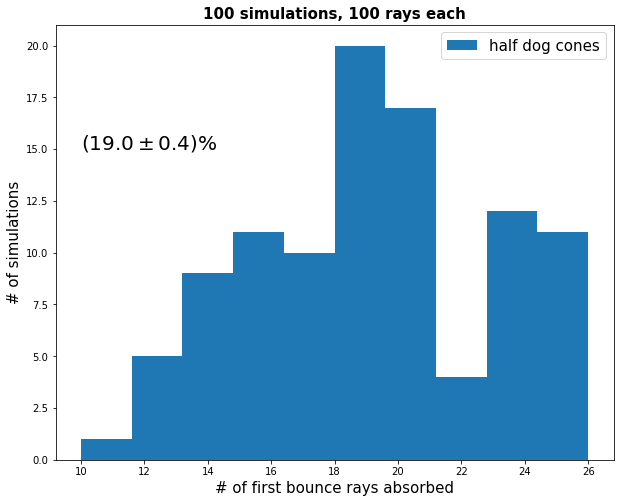

In [27]:
plt.figure(figsize=(10,8))
plt.hist(res_arr,bins=10,label='half dog cones')
plt.title('100 simulations, 100 rays each',fontdict={'size':15,'weight':'bold'})
plt.text(10,15,r'$(19.0\pm 0.4)$%',fontdict={'size':20})
plt.xlabel('# of first bounce rays absorbed',fontdict={'size':15})
plt.ylabel('# of simulations',fontdict={'size':15})
plt.legend(fontsize=15)
plt.show()

In [28]:
print(res_arr)

[14. 21. 18. 17. 18. 24. 20. 22. 22. 21. 25. 15. 18. 14. 17. 26. 21. 22.
 20. 12. 22. 14. 24. 25. 16. 19. 21. 18. 21. 19. 13. 26. 23. 16. 24. 14.
 16. 16. 20. 21. 17. 23. 20. 26. 20. 14. 16. 17. 15. 16. 25. 12. 23. 18.
 17. 18. 20. 26. 14. 26. 24. 18. 24. 14. 18. 19. 21. 24. 10. 18. 14. 19.
 17. 21. 20. 18. 19. 13. 21. 16. 18. 25. 23. 18. 17. 26. 24. 17. 13. 20.
 25. 19. 17. 23. 17. 18. 15. 15. 14. 19.]
